In [17]:

!pip install -q scikit-learn tensorflow pandas matplotlib seaborn joblib


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [19]:
urls = [
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00684/ObesityDataSet_raw_and_data_synthetic.csv",
    "https://raw.githubusercontent.com/RohitG57/Estimation-of-obesity-levels-based-on-eating-habits-and-physical-condition/main/ObesityDataSet_raw_and_data_sinthetic.csv",
    "https://raw.githubusercontent.com/kanhaiya-S/ML_project/main/ObesityDataSet_raw_and_data_sinthetic.csv"
]

df = None
for url in urls:
    try:
        print("Mencoba:", url)
        df = pd.read_csv(url)
        print("Berhasil load dari:", url)
        break
    except Exception as e:
        print("Gagal:", url, "| Error:", e)

if df is None:
    from google.colab import files
    print("Gagal unduh otomatis — silakan upload file CSV (ObesityDataSet_raw_and_data_sinthetic.csv).")
    uploaded = files.upload()
    fn = list(uploaded.keys())[0]
    df = pd.read_csv(fn)

display(df.head())
print("\nShape:", df.shape)
display(df.info())


Mencoba: https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic.csv
Gagal: https://archive.ics.uci.edu/ml/machine-learning-databases/00544/ObesityDataSet_raw_and_data_sinthetic.csv | Error: HTTP Error 404: Not Found
Mencoba: https://archive.ics.uci.edu/ml/machine-learning-databases/00684/ObesityDataSet_raw_and_data_synthetic.csv
Gagal: https://archive.ics.uci.edu/ml/machine-learning-databases/00684/ObesityDataSet_raw_and_data_synthetic.csv | Error: HTTP Error 404: Not Found
Mencoba: https://raw.githubusercontent.com/RohitG57/Estimation-of-obesity-levels-based-on-eating-habits-and-physical-condition/main/ObesityDataSet_raw_and_data_sinthetic.csv
Berhasil load dari: https://raw.githubusercontent.com/RohitG57/Estimation-of-obesity-levels-based-on-eating-habits-and-physical-condition/main/ObesityDataSet_raw_and_data_sinthetic.csv


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II



Shape: (2111, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF            

None

In [20]:
df.columns = df.columns.str.strip()
print("Kolom dataset:", df.columns.tolist(), "\n")
print("Unique values per column:")
for c in df.columns:
    print(f" - {c}: {df[c].nunique()}")

possible_targets = [c for c in df.columns if 'ob' in c.lower() or 'nob' in c.lower()]
print("\nKemungkinan kolom target (deteksi otomatis):", possible_targets)

target_col = "NObeyesdad" if "NObeyesdad" in df.columns else possible_targets[-1]
print("\nTarget kolom digunakan:", target_col)
print("\nDistribusi kelas target:")
print(df[target_col].value_counts())


Kolom dataset: ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'] 

Unique values per column:
 - Gender: 2
 - Age: 1402
 - Height: 1574
 - Weight: 1525
 - family_history_with_overweight: 2
 - FAVC: 2
 - FCVC: 810
 - NCP: 635
 - CAEC: 4
 - SMOKE: 2
 - CH2O: 1268
 - SCC: 2
 - FAF: 1190
 - TUE: 1129
 - CALC: 4
 - MTRANS: 5
 - NObeyesdad: 7

Kemungkinan kolom target (deteksi otomatis): ['NObeyesdad']

Target kolom digunakan: NObeyesdad

Distribusi kelas target:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


In [21]:
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ct = ColumnTransformer([
    ("ohe", ohe, cat_cols),
    ("pass", "passthrough", num_cols)
])

X_enc = ct.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_enc, num_classes)

print("X_enc shape:", X_enc.shape)
print("class names:", list(le.classes_))


Numerical columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
X_enc shape: (2111, 31)
class names: ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y_cat, test_size=0.2, random_state=42, stratify=y_enc)

scaler = StandardScaler()
if len(num_cols) > 0:
    n_ohe = X_enc.shape[1] - len(num_cols)
    X_train[:, n_ohe:] = scaler.fit_transform(X_train[:, n_ohe:])
    X_test[:, n_ohe:]  = scaler.transform(X_test[:, n_ohe:])
else:
    print("Tidak ada kolom numerik untuk distandardisasi.")

print("Shapes -> X_train, X_test, y_train, y_test:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes -> X_train, X_test, y_train, y_test: (1688, 31) (423, 31) (1688, 7) (423, 7)


In [23]:
def build_model(input_dim, hidden1=128, hidden2=64, dropout_rate=0.25, lr=0.001, num_classes=7):
    model = Sequential()
    model.add(Dense(hidden1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_dim = X_train.shape[1]
model = build_model(input_dim, hidden1=128, hidden2=64, dropout_rate=0.25, num_classes=num_classes)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,807 (50.03 KB)

 Trainable params: 12,807 (50.03 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
chk_path = "best_obesity_model.h5"
mc = ModelCheckpoint(chk_path, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.15,
                    epochs=100,
                    batch_size=32,
                    callbacks=[es, mc],
                    verbose=2)


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.41325, saving model to best_obesity_model.h5


45/45 - 2s - 55ms/step - accuracy: 0.3619 - loss: 1.6747 - val_accuracy: 0.5236 - val_loss: 1.4132
Epoch 2/100

Epoch 2: val_loss improved from 1.41325 to 1.06594, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.5676 - loss: 1.2304 - val_accuracy: 0.6496 - val_loss: 1.0659
Epoch 3/100

Epoch 3: val_loss improved from 1.06594 to 0.84535, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.6199 - loss: 0.9891 - val_accuracy: 0.7205 - val_loss: 0.8454
Epoch 4/100

Epoch 4: val_loss improved from 0.84535 to 0.73246, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.6667 - loss: 0.8359 - val_accuracy: 0.7835 - val_loss: 0.7325
Epoch 5/100

Epoch 5: val_loss improved from 0.73246 to 0.62892, saving model to best_obesity_model.h5


45/45 - 0s - 4ms/step - accuracy: 0.7190 - loss: 0.7283 - val_accuracy: 0.8268 - val_loss: 0.6289
Epoch 6/100

Epoch 6: val_loss improved from 0.62892 to 0.54327, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.7531 - loss: 0.6422 - val_accuracy: 0.8307 - val_loss: 0.5433
Epoch 7/100

Epoch 7: val_loss improved from 0.54327 to 0.49204, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.7699 - loss: 0.5855 - val_accuracy: 0.8425 - val_loss: 0.4920
Epoch 8/100

Epoch 8: val_loss improved from 0.49204 to 0.46253, saving model to best_obesity_model.h5


45/45 - 0s - 7ms/step - accuracy: 0.7985 - loss: 0.5441 - val_accuracy: 0.8543 - val_loss: 0.4625
Epoch 9/100

Epoch 9: val_loss improved from 0.46253 to 0.40074, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.8236 - loss: 0.4869 - val_accuracy: 0.8661 - val_loss: 0.4007
Epoch 10/100

Epoch 10: val_loss improved from 0.40074 to 0.37390, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.8187 - loss: 0.4719 - val_accuracy: 0.8937 - val_loss: 0.3739
Epoch 11/100

Epoch 11: val_loss improved from 0.37390 to 0.34970, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.8494 - loss: 0.4178 - val_accuracy: 0.8976 - val_loss: 0.3497
Epoch 12/100

Epoch 12: val_loss improved from 0.34970 to 0.31978, saving model to best_obesity_model.h5


45/45 - 0s - 4ms/step - accuracy: 0.8508 - loss: 0.3867 - val_accuracy: 0.9055 - val_loss: 0.3198
Epoch 13/100

Epoch 13: val_loss improved from 0.31978 to 0.29775, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.8787 - loss: 0.3611 - val_accuracy: 0.9173 - val_loss: 0.2978
Epoch 14/100

Epoch 14: val_loss improved from 0.29775 to 0.28563, saving model to best_obesity_model.h5


45/45 - 0s - 4ms/step - accuracy: 0.8738 - loss: 0.3566 - val_accuracy: 0.9134 - val_loss: 0.2856
Epoch 15/100

Epoch 15: val_loss improved from 0.28563 to 0.27512, saving model to best_obesity_model.h5


45/45 - 0s - 4ms/step - accuracy: 0.8842 - loss: 0.3316 - val_accuracy: 0.9055 - val_loss: 0.2751
Epoch 16/100

Epoch 16: val_loss improved from 0.27512 to 0.26389, saving model to best_obesity_model.h5


45/45 - 0s - 7ms/step - accuracy: 0.8933 - loss: 0.3111 - val_accuracy: 0.9409 - val_loss: 0.2639
Epoch 17/100

Epoch 17: val_loss improved from 0.26389 to 0.25355, saving model to best_obesity_model.h5


45/45 - 1s - 14ms/step - accuracy: 0.8877 - loss: 0.3005 - val_accuracy: 0.9331 - val_loss: 0.2535
Epoch 18/100

Epoch 18: val_loss improved from 0.25355 to 0.24520, saving model to best_obesity_model.h5


45/45 - 1s - 14ms/step - accuracy: 0.8961 - loss: 0.2775 - val_accuracy: 0.9370 - val_loss: 0.2452
Epoch 19/100

Epoch 19: val_loss improved from 0.24520 to 0.23323, saving model to best_obesity_model.h5


45/45 - 0s - 7ms/step - accuracy: 0.9163 - loss: 0.2516 - val_accuracy: 0.9173 - val_loss: 0.2332
Epoch 20/100

Epoch 20: val_loss did not improve from 0.23323
45/45 - 0s - 6ms/step - accuracy: 0.9107 - loss: 0.2596 - val_accuracy: 0.9331 - val_loss: 0.2367
Epoch 21/100

Epoch 21: val_loss improved from 0.23323 to 0.22422, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9205 - loss: 0.2389 - val_accuracy: 0.9488 - val_loss: 0.2242
Epoch 22/100

Epoch 22: val_loss improved from 0.22422 to 0.21675, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9093 - loss: 0.2418 - val_accuracy: 0.9370 - val_loss: 0.2167
Epoch 23/100

Epoch 23: val_loss improved from 0.21675 to 0.20655, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9351 - loss: 0.2153 - val_accuracy: 0.9449 - val_loss: 0.2065
Epoch 24/100

Epoch 24: val_loss did not improve from 0.20655
45/45 - 0s - 4ms/step - accuracy: 0.9226 - loss: 0.2146 - val_accuracy: 0.9409 - val_loss: 0.2067
Epoch 25/100

Epoch 25: val_loss improved from 0.20655 to 0.20631, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9282 - loss: 0.1912 - val_accuracy: 0.9409 - val_loss: 0.2063
Epoch 26/100

Epoch 26: val_loss improved from 0.20631 to 0.20282, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9303 - loss: 0.1963 - val_accuracy: 0.9331 - val_loss: 0.2028
Epoch 27/100

Epoch 27: val_loss improved from 0.20282 to 0.18791, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9414 - loss: 0.1844 - val_accuracy: 0.9449 - val_loss: 0.1879
Epoch 28/100

Epoch 28: val_loss did not improve from 0.18791
45/45 - 0s - 4ms/step - accuracy: 0.9463 - loss: 0.1696 - val_accuracy: 0.9449 - val_loss: 0.2034
Epoch 29/100

Epoch 29: val_loss improved from 0.18791 to 0.18489, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9317 - loss: 0.1874 - val_accuracy: 0.9449 - val_loss: 0.1849
Epoch 30/100

Epoch 30: val_loss improved from 0.18489 to 0.17298, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9428 - loss: 0.1672 - val_accuracy: 0.9488 - val_loss: 0.1730
Epoch 31/100

Epoch 31: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9414 - loss: 0.1633 - val_accuracy: 0.9409 - val_loss: 0.1797
Epoch 32/100

Epoch 32: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9456 - loss: 0.1461 - val_accuracy: 0.9449 - val_loss: 0.1844
Epoch 33/100

Epoch 33: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9519 - loss: 0.1422 - val_accuracy: 0.9449 - val_loss: 0.1803
Epoch 34/100

Epoch 34: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9644 - loss: 0.1254 - val_accuracy: 0.9488 - val_loss: 0.1799
Epoch 35/100

Epoch 35: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9449 - loss: 0.1431 - val_accuracy: 0.9449 - val_loss: 0.1864
Epoch 36/100

Epoch 36: val_loss did not improve from 0.17298
45/45 - 0s - 4ms/step - accuracy: 0.9512

45/45 - 0s - 5ms/step - accuracy: 0.9630 - loss: 0.1173 - val_accuracy: 0.9528 - val_loss: 0.1726
Epoch 38/100

Epoch 38: val_loss did not improve from 0.17264
45/45 - 0s - 4ms/step - accuracy: 0.9637 - loss: 0.1146 - val_accuracy: 0.9488 - val_loss: 0.1822
Epoch 39/100

Epoch 39: val_loss improved from 0.17264 to 0.15189, saving model to best_obesity_model.h5


45/45 - 0s - 5ms/step - accuracy: 0.9554 - loss: 0.1273 - val_accuracy: 0.9528 - val_loss: 0.1519
Epoch 40/100

Epoch 40: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9596 - loss: 0.1174 - val_accuracy: 0.9567 - val_loss: 0.1590
Epoch 41/100

Epoch 41: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9616 - loss: 0.1101 - val_accuracy: 0.9606 - val_loss: 0.1640
Epoch 42/100

Epoch 42: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9582 - loss: 0.1082 - val_accuracy: 0.9488 - val_loss: 0.1762
Epoch 43/100

Epoch 43: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9596 - loss: 0.1115 - val_accuracy: 0.9528 - val_loss: 0.1804
Epoch 44/100

Epoch 44: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9616 - loss: 0.1011 - val_accuracy: 0.9370 - val_loss: 0.1994
Epoch 45/100

Epoch 45: val_loss did not improve from 0.15189
45/45 - 0s - 4ms/step - accuracy: 0.9644

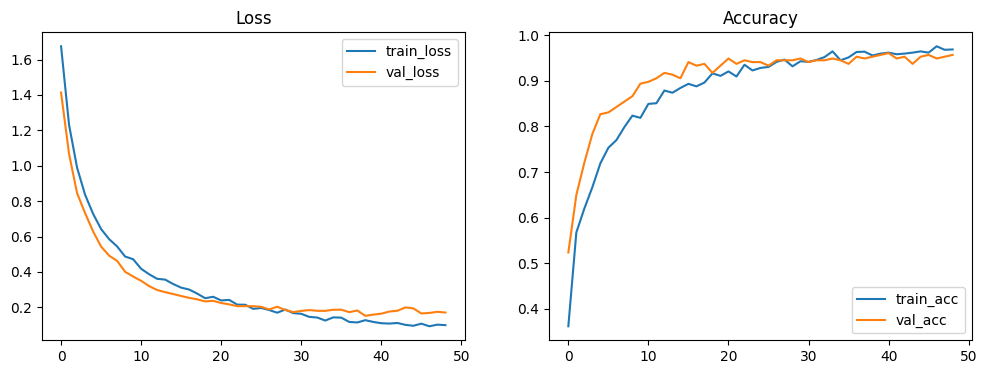

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test Accuracy: 0.933806146572104
Test F1-score (macro): 0.9309799755202641


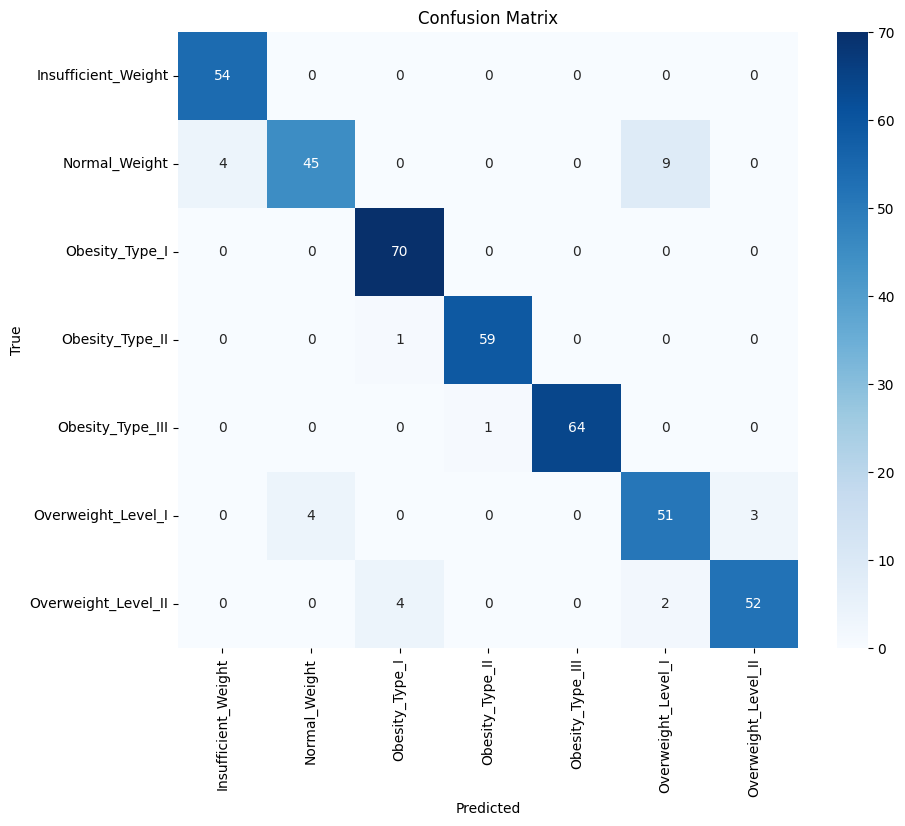

                     precision    recall  f1-score   support

Insufficient_Weight       0.93      1.00      0.96        54
      Normal_Weight       0.92      0.78      0.84        58
     Obesity_Type_I       0.93      1.00      0.97        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.82      0.88      0.85        58
Overweight_Level_II       0.95      0.90      0.92        58

           accuracy                           0.93       423
          macro avg       0.93      0.93      0.93       423
       weighted avg       0.93      0.93      0.93       423



In [26]:
model.load_weights(chk_path)
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
print("Test Accuracy:", acc)
print("Test F1-score (macro):", f1_macro)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel('True'); plt.xlabel('Predicted'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=le.classes_))


In [27]:
model.save("final_obesity_model.h5")
joblib.dump(ct, "column_transformer.joblib")
joblib.dump(le, "label_encoder.joblib")
joblib.dump(scaler, "scaler.joblib")
print("Saved artifacts: final_obesity_model.h5, column_transformer.joblib, label_encoder.joblib, scaler.joblib")


Saved artifacts: final_obesity_model.h5, column_transformer.joblib, label_encoder.joblib, scaler.joblib
